<h1><center>Loan Paid-Off Prediction </center></h1>

## Data Description

This dataset is about past loans. The Loan_train.csv data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

1. **Loan_status**: Whether a loan is paid off or in collection
2. **Principal**: Basic principal loan amount
3. **Terms**: Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule
4. **Effective_date**: When the loan got originated and took effects
5. **Due_date**: Since it’s one-time payoff schedule, each loan has one single due date
6. **Age**: Age of applicant
7. **Education**: Education of applicant
8. **Gender**: Gender of applicant

In [1]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-04-07 05:01:11--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.001s  

2019-04-07 05:01:11 (15.4 MB/s) - ‘loan_train.csv’ saved [23101/23101]



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, jaccard_similarity_score, log_loss
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Read training and test data set
df_train = pd.read_csv('loan_train.csv')
print('Training Set Shape:', df_train.shape)

Training Set Shape: (346, 10)


In [4]:
print('First 5 rows of Training Data:')
df_train.head()

First 5 rows of Training Data:


,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [5]:
#No null value in dataset
df_train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 10 columns):
Unnamed: 0        346 non-null int64
Unnamed: 0.1      346 non-null int64
loan_status       346 non-null object
Principal         346 non-null int64
terms             346 non-null int64
effective_date    346 non-null object
due_date          346 non-null object
age               346 non-null int64
education         346 non-null object
Gender            346 non-null object
dtypes: int64(5), object(5)
memory usage: 27.1+ KB


## Data Preprocessing

In [6]:
def preprocess(df):
    # Drop 'Unname' variable since train set and test set have been merged.
    df = df.drop(["Unnamed: 0", "Unnamed: 0.1"], axis=1).reset_index(drop=True)

    #Extract day_of_week and day_of_month from due_date. we will check which period of week or month will effect the loan paid-off,
    #Since the students may receive some income from parttime job at end of week or month.  
    df.effective_date = pd.to_datetime(df.effective_date)
    df.due_date = pd.to_datetime(df.due_date)

    df['day_of_week'] = df.due_date.dt.dayofweek
    df['weekend'] = df.day_of_week.apply(lambda x: 1 if x>3 else 0)

    df['day_of_month'] = df.due_date.dt.day
    def day(x):
        if x < 10:
            return 0
        elif x < 20:
            return 1
        else:
            return 2
    df['early_middle_late_of_month'] = df.day_of_month.apply(day)
    return df

In [7]:
df = preprocess(df_train)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,day_of_week,weekend,day_of_month,early_middle_late_of_month
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,4,1,7,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,4,1,7,0
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0,22,2
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,5,1,8,0
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,5,1,8,0


In [8]:
#Check targer variable count
df.loan_status.value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

## Data Visualisation

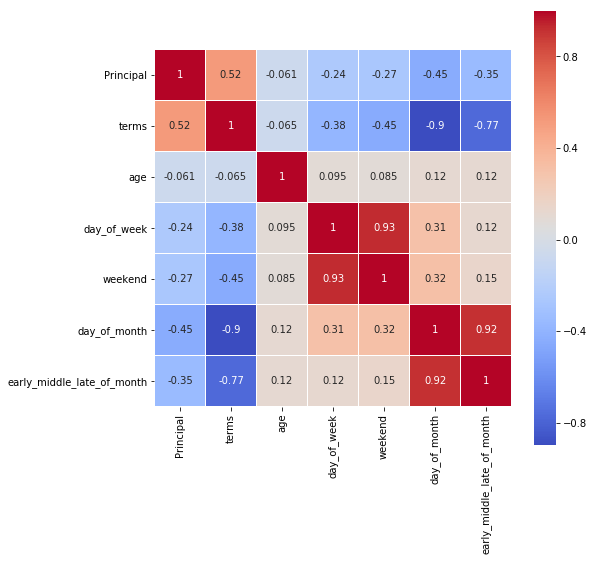

In [9]:
#Plot heat map to check correlation between features
fig = plt.figure(figsize=(8,8))
sns.heatmap(df.corr(), annot=True, linewidth=0.8, square=True, cmap='coolwarm')

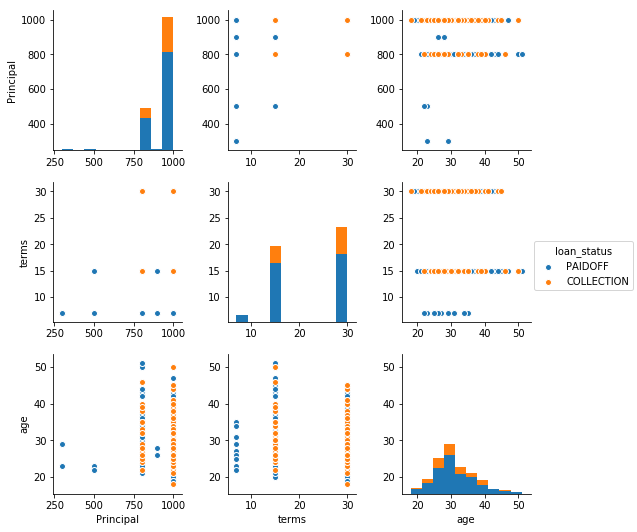

In [10]:
# Pairplot for numerical data, 
# From graph below, the numerical data actually will be performed like categorical data.
fig = plt.figure(figsize=(20,20))
sns.pairplot(df[["loan_status", "Principal", "terms", "age"]], hue="loan_status")

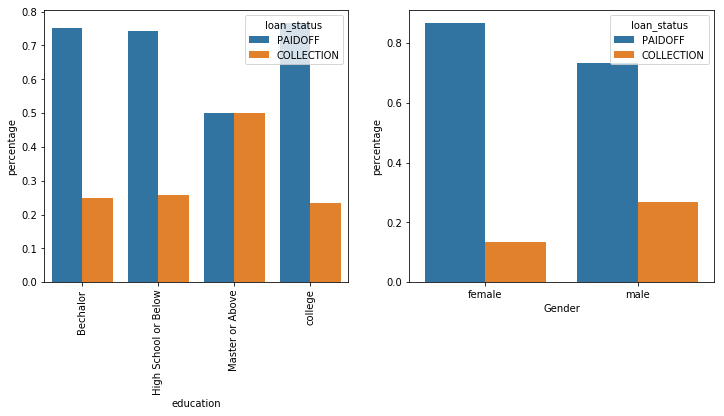

In [11]:
# Let's see how education and gender of applicant impact the loan paid-off
# Seems applicants who have holding bachelor degree will most likely pay off loan, 
# applicants whoes education is high school or below are least percentage to pay off loan.
# Female applicants will more likely pay off loan.
edu_count = df.groupby(['education']).size().reset_index().rename(columns={0:'count1'})
edu_loan_count = df.groupby(['loan_status', 'education']).size().reset_index().rename(columns={0:'count'})

edu_merge = edu_count.merge(edu_loan_count, on='education')
edu_merge['percentage'] = edu_merge['count']/edu_merge['count1']
edu_merge.sort_values(['loan_status'], ascending=False, inplace=True)
edu_merge.sort_values(['education'], inplace=True)

gender_count = df.groupby(['Gender']).size().reset_index().rename(columns={0:'count1'})
gender_loan_count = df.groupby(['loan_status', 'Gender']).size().reset_index().rename(columns={0:'count'})

gender_merge = gender_count.merge(gender_loan_count, on='Gender')
gender_merge['percentage'] = gender_merge['count']/gender_merge['count1']
gender_merge.sort_values('loan_status', ascending=False, inplace=True)

fig= plt.figure(figsize=(12,5))

ax1 = plt.subplot(121)
ax1 = sns.barplot(x='education', y='percentage', hue='loan_status', data=edu_merge)
ax1.set_xticklabels(edu_merge.education.unique(), rotation=90)

ax2 = plt.subplot(122)
ax2 = sns.barplot(x='Gender', y='percentage', hue='loan_status', data=gender_merge)

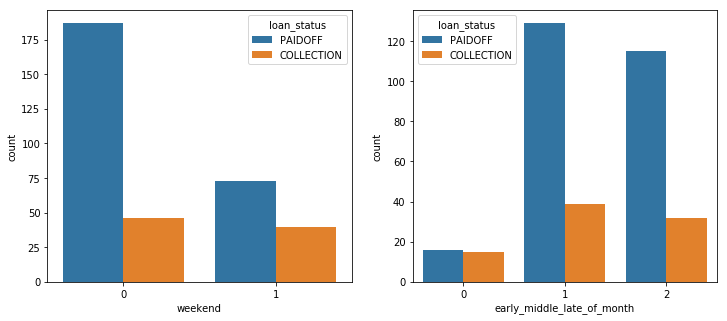

In [12]:
# Let's see how the date impact the loan paid-off
# Seems applicants whoes loan due_date on early of week and month more likely pay off the loan.
# This is because the income are always received on end of week and month, thus they have enough money to pay off the loan.

fig = plt.figure(figsize=(12, 5))

ax1 = plt.subplot(121)
ax1 = sns.countplot(x='weekend', hue='loan_status', data=df)

ax2 = plt.subplot(122)
ax2 = sns.countplot(x='early_middle_late_of_month', hue='loan_status', data=df)

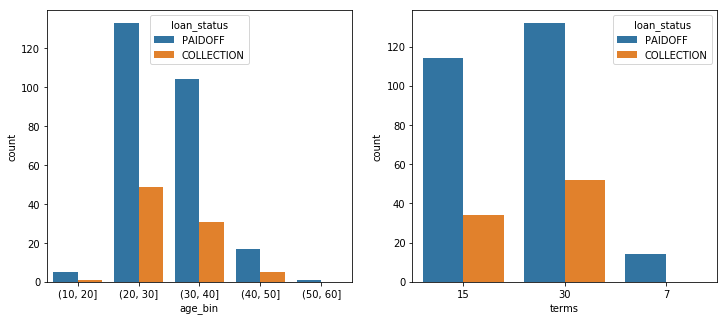

In [13]:
# Seems all applicants elder than 50 have paid off the loan.
# And all applicants with short terms (7 days terms) have paid off loan as well

bins = [10, 20, 30, 40, 50, 60]
df['age_bin'] = pd.cut(df.age, bins=bins)

df.terms = df.terms.astype(str)

fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot(121)
ax1 = sns.countplot(x='age_bin', data=df, hue='loan_status')

ax2 = plt.subplot(122)
ax2 = sns.countplot(x='terms', hue='loan_status', data=df)

df.terms = df.terms.astype(int)

(15, 60)

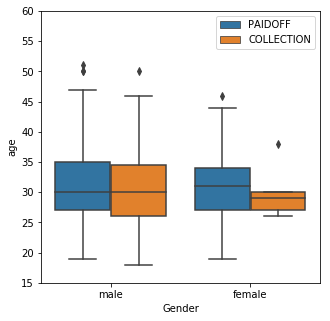

In [14]:
# From plot below, older female will more likely pay off loan.
fig = plt.figure(figsize=(5,5))
sns.boxplot(x='Gender', y='age', hue='loan_status', data=df)
plt.legend(loc='upper right')
plt.ylim(15,60)

## Feature Selection

In [15]:
featselec = ['loan_status',
             'Principal',
             'terms',
#              'effective_date',
#              'due_date',
             'age',
             'education',
             'Gender',
#              'day_of_week',
             'weekend',
#              'day_of_month',
             'early_middle_late_of_month'
#              'age_bin',
#              'terms_bin'
            ]

df = df[featselec]

### Label Encoding and One Hot Encoding

In [16]:
label_encoder = LabelEncoder().fit(df.Gender)
df.Gender = label_encoder.transform(df.Gender)
X = pd.get_dummies(df.drop('loan_status', axis=1))
y = df.loan_status.replace({'PAIDOFF':0, 'COLLECTION':1})

## Model Training

### K Nearest Neighbors
As KNN is distance based algorithm, data normalization is required for KNN to improve model performance.  

In [17]:
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(242, 10) (104, 10) (242,) (104,)


In [18]:
# Select k value for best porformed model
Ks = 10
mean_f1 = np.zeros((Ks-1))
std_f1 = np.zeros((Ks-1))
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_f1[n-1] = f1_score(y_test, yhat, average='weighted')    
    std_f1[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

print(mean_f1)
print('\nk number with best F1-Score:', mean_f1.argmax()+1)

[ 0.66220365  0.67460317  0.66225523  0.68007744  0.66886447  0.71166811
  0.68867248  0.68166716  0.67352415]

k number with best F1-Score: 6


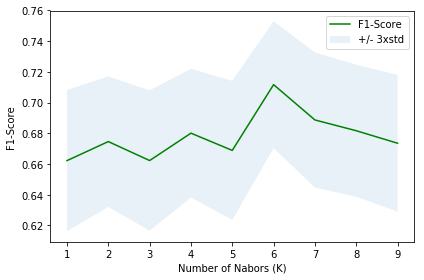

In [19]:
plt.plot(range(1,Ks),mean_f1,'g')
plt.fill_between(range(1,Ks),mean_f1 - 1 * std_f1,mean_f1 + 1 * std_f1, alpha=0.10)
plt.legend(('F1-Score ', '+/- 3xstd'))
plt.ylabel('F1-Score ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [20]:
k = mean_f1.argmax()+1
knn = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
yhat = knn.predict(X_test)
print("F1-Score for KNN:", f1_score(y_test, yhat, average='weighted'))
print('Jaccard Similarity Score for KNN:', jaccard_similarity_score(y_test, yhat))

F1-Score for KNN: 0.711668107174
Jaccard Similarity Score for KNN: 0.769230769231


### Decision Tree Model

It is not necessary to normalize dataset for tree based model  

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(242, 10) (104, 10) (242,) (104,)


[ 0.69323842  0.77285396  0.75445452  0.76056636  0.76056636  0.74273053
  0.76923077  0.74273053  0.77866159  0.75318616  0.76428571  0.74615385]

Max_Depth number with best F1-Score: 11


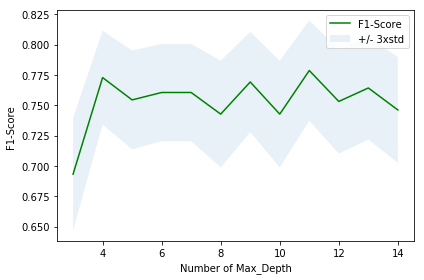

In [22]:
max_depth = 15
mean_f1 = np.zeros((max_depth-3))
std_f1 = np.zeros((max_depth-3))
for n in range(3,max_depth):
    
    #Train Model and Predict  
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=n, random_state=0).fit(X_train,y_train)
    yhat=clf.predict(X_test)
    mean_f1[n-3] = f1_score(y_test, yhat, average='weighted')    
    std_f1[n-3]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

print(mean_f1)
print('\nMax_Depth number with best F1-Score:', mean_f1.argmax()+3)

plt.plot(range(3,max_depth),mean_f1,'g')
plt.fill_between(range(3,max_depth),mean_f1 - 1 * std_f1,mean_f1 + 1 * std_f1, alpha=0.10)
plt.legend(('F1-Score ', '+/- 3xstd'))
plt.ylabel('F1-Score ')
plt.xlabel('Number of Max_Depth')
plt.tight_layout()
plt.show()

In [23]:
max_depth = mean_f1.argmax()+3
dt = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=0).fit(X_train, y_train)
yhat = dt.predict(X_test)
print("F1-Score for Desicion Tree Model:", f1_score(y_test, yhat, average='weighted'))
print('Jaccard Similarity Score for Decision Tree Model:', jaccard_similarity_score(y_test, yhat))

F1-Score for Desicion Tree Model: 0.778661586092
Jaccard Similarity Score for Decision Tree Model: 0.769230769231


### Support Vector Machine

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(242, 10) (104, 10) (242,) (104,)


In [25]:
svc = SVC(kernel='rbf', random_state=0).fit(X_train, y_train)
yhat = svc.predict(X_test)
print("F1-Score for SVM Model:", f1_score(y_test, yhat, average='weighted'))
print('Jaccard Similarity Score for SVM Model:', jaccard_similarity_score(y_test, yhat))

F1-Score for SVM Model: 0.742595639654
Jaccard Similarity Score for SVM Model: 0.798076923077


### Logistic Regression

In [26]:
lg = LogisticRegression(C=0.01, solver='liblinear', random_state=0).fit(X_train, y_train)
yhat = lg.predict(X_test)
print("F1-Score for Logistic Regression Model:", f1_score(y_test, yhat, average='weighted'))
print('Jaccard Similarity Score for Logistic Regression Model:', jaccard_similarity_score(y_test, yhat))
print('Log Loss for Logistic Regression Model:', log_loss(y_test, yhat))

F1-Score for Logistic Regression Model: 0.755794088403
Jaccard Similarity Score for Logistic Regression Model: 0.798076923077
Log Loss for Logistic Regression Model: 6.974214445


## Model Evaluation Using Test Set

In [27]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-04-07 05:01:17--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-04-07 05:01:17 (649 MB/s) - ‘loan_test.csv’ saved [3642/3642]



In [28]:
df_test = pd.read_csv('loan_test.csv')
print('First 5 rows of Test Data:')
df_test.head()

First 5 rows of Test Data:


,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [29]:
df_test = preprocess(df_test)
df_test = df_test[featselec]
df_test.Gender = label_encoder.transform(df_test.Gender)
X_test = pd.get_dummies(df_test.drop('loan_status', axis=1))
y_test = df_test.loan_status.replace({'PAIDOFF':0, 'COLLECTION':1})
X_test_scaled = scaler.transform(X_test)

### Evaluation for KNN model

In [30]:
#Evaluation for KNN model
yhat = knn.predict(X_test_scaled)
print("F1-Score for KNN:", f1_score(y_test, yhat, average='weighted'))
print('Jaccard Similarity Score for KNN:', jaccard_similarity_score(y_test, yhat))

F1-Score for KNN: 0.657912457912
Jaccard Similarity Score for KNN: 0.703703703704


### Evaluation for Desicion Tree model

In [31]:
#Evaluation for Desicion Tree model
yhat = dt.predict(X_test)
print("F1-Score for Decision Tree Model:", f1_score(y_test, yhat, average='weighted'))
print('Jaccard Similarity Score for Decision Tree Model:', jaccard_similarity_score(y_test, yhat))

F1-Score for Decision Tree Model: 0.681298582533
Jaccard Similarity Score for Decision Tree Model: 0.685185185185


### Evaluation for SVM model

In [32]:
#Evaluation for SVM model
yhat = svc.predict(X_test_scaled)
print("F1-Score for SVM Model:", f1_score(y_test, yhat, average='weighted'))
print('Jaccard Similarity Score for SVM Model:', jaccard_similarity_score(y_test, yhat))

F1-Score for SVM Model: 0.637860082305
Jaccard Similarity Score for SVM Model: 0.703703703704


### Evaluation for Logistic Regression model

In [33]:
#Evaluation for Logistic Regression Model
yhat = lg.predict(X_test_scaled)
print("F1-Score for Logistic Regression Model:", f1_score(y_test, yhat, average='weighted'))
print('Jaccard Similarity Score for Logistic Regression Model:', jaccard_similarity_score(y_test, yhat))
print('Log Loss for Logistic Regression Model:', log_loss(y_test, yhat))

F1-Score for Logistic Regression Model: 0.758350307729
Jaccard Similarity Score for Logistic Regression Model: 0.796296296296
Log Loss for Logistic Regression Model: 7.0356914804


## Report 

Report the evaluation accuracy of the built model for test dataset using different evaluation metrics :

|    Model    | Jaccard | F1-Score | Log-Loss |
|-------------|---------|----------|----------|
|KNN          | 0.704   | 0.658    | N/A      |
|Decision Tree| 0.685   | 0.681    | N/A      |
|SVM          | 0.704   | 0.638    | N/A      |
|Logistic Regression| 0.796 | 0.758 | 7.036 |